# Actor-Critic network for shortest path with PubMedBERT embeddings

In this notebook we experiment with replacing the GraphSAGE embeddings by PubMedBERT in the initial actor-critic pathfinding notebook.

We find that the performance is similar to that of the GraphSAGE embeddings. 

In [2]:
import pandas as pd
import polars as pl # much faster than pandas
import numpy as np
import matplotlib.pyplot as plt
import igraph as ig
import torch
import torch.nn as nn
import torch.nn.functional as F

from time import time
import random
import pickle
from tqdm import tqdm
import sys
import importlib

## KG environment

First, we set up the knowledge graph environment class which the agent interacts. 

A primary function of this class is to:
 - For any given node, be able to return all successor neighbour nodes and embeddings. 
 - For any given node, be able to return out-going edges and one-hot embeddings for their predicates.

As these operations are repeated in every training step, they must be done quickly. For instance, calling a neo4j server directly to achieve this in prohibitively slow. To achieve sufficient speed, we use the graph package igraph combined with PyTorch for dealing with the embeddings.  



In [3]:
# KG filepath
KG_NODES_PATH = '/Users/alexei/Documents/data/KGML_xDTD_data/KG/nodes_c.tsv'
KG_NODES_HEADER_PATH = '/Users/alexei/Documents/data/KGML_xDTD_data/KG/nodes_c_header.tsv'
KG_EDGES_PATH = '/Users/alexei/Documents/data/KGML_xDTD_data/KG/edges_c.tsv'
KG_EDGES_HEADER_PATH ='/Users/alexei/Documents/data/KGML_xDTD_data/KG/edges_c_header.tsv'
# GraphSAGE embeddings filepath 
GRAPHSAGE_EMB_PATH = '/Users/alexei/Documents/data/KGML_xDTD_data/data/entity_embeddings/unsuprvised_graphsage_entity_embeddings.pkl'
# PubMedBERT embeddings filepath 
PUBMED_EMB_PATH = '/Users/alexei/Documents/data/KGML_xDTD_data/data/entity_embeddings/embedding_biobert_namecat.pkl'

In [4]:
class KGEnv:
    """
    A class representing a knowledge graph enriched with embeddings.  
    """
    def __init__(self, 
                 kg_nodes_filepath: str,
                 kg_nodes_header_filepath: str,
                 kg_edges_filepath: str, 
                 kg_edges_header_filepath: str, 
                 embeddings_filepath: str,
                 id_col_name = "id:ID", 
                 predicate_col_name = "predicate",
                 subject_col_name = "subject",
                 object_col_name = "object", 
                 device = 'cpu'
                 ) -> None:
        """Initialises instance of the KGEnv class.

        Args:
            kg_nodes_filepath: File path for tsv file containing the KG nodes.
            kg_nodes_header_filepath: File path for tsv file containing the header for the KG nodes.
            kg_edges_filepath: File path for tsv file containing the KG edges.
            kg_edges_header_filepath: File path for tsv file containing the header for the KG edges.
            embeddings_filepath: File path for a pickle file containing an KG ID to embedding vector dictionary.
            id_col_name: Column name for KG ID in nodes tsv file.
            predicate_col_name: Column name for KG edge predicate in edges tsv file. 
            subject_col_name: Column name for KG edge subject in edges tsv file.
            object_col_name: Column name for KG edge object in edges tsv file.
        """
        self.device = device

        # Load nodes
        print("Loading nodes...")
        nodes_header = pd.read_csv(kg_nodes_header_filepath, sep='\t', header=None).iloc[0].to_list()
        df_nodes = pl.read_csv(kg_nodes_filepath, separator='\t', has_header= False, new_columns=nodes_header)
        df_nodes = df_nodes.with_row_index()
        # Load edges
        print("Loading edges...")
        edges_header = pd.read_csv(kg_edges_header_filepath, sep='\t', header=None).iloc[0].to_list()
        df_edges = pl.read_csv(kg_edges_filepath, separator='\t', has_header= False, new_columns=edges_header)
        
        # Generate KG ID to index dictionary for nodes
        print("Generating igraph Graph instance...")
        self.node_id_to_index = {key: val for key, val in zip(list(df_nodes[id_col_name]), list(df_nodes["index"]))}
        # Generate edge predicate to index dictionary
        unique_predicates = pl.DataFrame(df_edges[predicate_col_name].unique())
        unique_predicates = unique_predicates.with_row_index()
        self.edge_predicate_to_index = {key: val for key, val in zip(list(unique_predicates[predicate_col_name]), list(unique_predicates["index"]))}
        self.N_edge_labels = len(self.edge_predicate_to_index)
        # Generating igraph Graph instance
        edges = [(self.node_id_to_index[subject], self.node_id_to_index[object]) for subject, object in zip(df_edges[subject_col_name],df_edges[object_col_name])]
        edge_labels = {"edge_label":[self.edge_predicate_to_index[predicate] for predicate in df_edges[predicate_col_name]]}
        self.graph = ig.Graph(edges=edges, directed=True, edge_attrs = edge_labels)
        # Remove nodes and edges from memory
        del df_nodes
        del df_edges

        # Load embeddings
        print("Loading embeddings...")
        with open(embeddings_filepath, 'rb') as file:
            embedding_dict = pickle.load(file)
        # Dimensions of embeddings matrix
        self.N_emb = len(list(embedding_dict.values())[0])
        self.N_items = len(self.node_id_to_index)        
        # Generate 2d torch tensor for embeddings. If no embedding exists, we use the zero embedding
        print("Generating embeddings matrix...")
        self.embedding_matrix = torch.zeros((self.N_items, self.N_emb))
        for _id, n in self.node_id_to_index.items():
            if _id in embedding_dict.keys():
                self.embedding_matrix[n, :] = torch.tensor(embedding_dict[_id])
        self.embedding_matrix.to(device) 
        # Remove embedding dictionary from memory
        del embedding_dict

        # Matrix for one-hot edge embeddings
        self._edge_embedding_matrix = torch.eye(self.N_edge_labels).to(device)

        print("Initialisation successful.")


    def get_nhood_nodes(self, n: int) -> torch.Tensor:
        """Returns successor node indices and corresponding embeddings.

        Args:
            n: igraph node index

        Returns:
            Tuple where the:
                - first element is a list of indices for successor nodes. 
                - second element is a 2d torch tensor with the corresponding embeddings.
            If there are no successor nodes, then a tuple of two None objects is returned.
        """
        successor_list = self.graph.successors(n)
        if len(successor_list) == 0:
            return None, None
        else:
            return successor_list, self.embedding_matrix[successor_list]


    def get_out_edges(self, n: int) -> torch.Tensor:
        """Returns outgoing edge predicate indices and corresponding one-hot embeddings.

        Args:
            n: igraph node index

        Returns:
            Tuple where the:
                - first element is a list of indices for the predicates of all out edges. 
                - second element is a 2d torch tensor with the one-hot embeddings.
            If there are outgoing edges, then a tuple of two None objects is returned.
        """
        # Get indices of out edges
        edge_list = self.graph.vs[n].out_edges()
        if len(edge_list) == 0:
            return None, None
        edge_labels_lst = [edge["edge_label"] for edge in edge_list]
        # Return corresponding one-hot embeddings
        return edge_labels_lst, self._edge_embedding_matrix[edge_labels_lst]

In [5]:
# Initialise KG environment
kg_env = KGEnv(KG_NODES_PATH, KG_NODES_HEADER_PATH, KG_EDGES_PATH, KG_EDGES_HEADER_PATH, PUBMED_EMB_PATH)

Loading nodes...
Loading edges...
Generating igraph Graph instance...
Loading embeddings...
Generating embeddings matrix...
Initialisation successful.


## State representation

Let $u$ represent the source drug and the $v$ the target disease. 

At each time step $t$, the agent performs an action consisting in traversing from one node $e_t$ to another $e_{t+1}$ across an edge with a given label $r_{t+1}$ .  An action is represented by a tuple $a_t = (e_{t+1}, r_{t+1})$, where $r_{t+1}$ is the edge predicate index and $e_{t+1}$ is the igraph index for the new node. 

Future actions depends only on the current state. 

There are two options for representing the state. Let $K \in \mathbb{N}$ be a cap on the number of edges in a path. 
1. Target disease accessible:
$$ s_t = [u, v, (e_{t-K}, r_{t-K}), ..., (e_{t-1}, r_{t-1}), (e_{t}, r_{t})]$$
2. Target disease inaccessible:
$$ s_t = [u, (e_{t-K}, r_{t-K}), ..., (e_{t-1}, r_{t-1}), (e_{t}, r_{t})]$$

The first corresponds to the case where the agent makes MOA predictions after a drug-disease relationship has already been made. 

The second corresponds to the case where the agent finds make disease predictions for a given drug and simultaneously provides MOA predictions. 

Zhou et. al. and KGML-xDTD opt for the second option. We shall initially focus on the first option for the $u \rightarrow v$ path-finding problem. 

**Note:** If $t \leq 0$, we replace $(e_{t}, r_{t})$ by a dummy variable $(-1,-1)$. For instance, in the first option above the initial state is
$$s_0 = (u, v, (-1,-1),...,(-1,-1)).$$

*Remark.* We could in principle let the maximum number of edges in a path be greater than the history included in the state.  

In [6]:
# Maximum allowed number of edges in a path
K = 5 

In [7]:
class Agent:
    """A class representing a reinforcement learning agent in a knowledge graph environment.  
    """
    def __init__(self, K: int, kg_env: KGEnv) -> None:
        """Initialises Agent instance.

        Args:
            K: Maximum allowed number of edges in a path
            kg_env: Instance of KGEnv 
        """
        self.K = K
        self.kg_env = kg_env
        # Initiate time
        self.time = 0
        # Initialise empty state attributes
        self.reset()

    def set_source_target(self, drug : int, disease :int) -> None:
        """Sets source drug and target diseases. Resets state to canonical initial state.  

        Args:
            drug: igraph node index for the source drug
            disease: igraph node index for the target drug
        """
        # Reset time and termination status
        self.time = 0
        self.terminated = False

        # Set drug and disease indices
        self.source_drug = drug
        self.target_disease = disease
        
        # Set drug and disease embeddings
        self.source_drug_embedding = self.kg_env.embedding_matrix[drug]
        self.target_disease_embedding = self.kg_env.embedding_matrix[disease]

        # Set initial state
        self.current_state = [drug, disease] + [(-1,-1) for _ in range(self.K)]
        self.current_node = drug
        # Set initial state embedding matrix
        embeddings_tmp = torch.zeros((self.K + 2, self.kg_env.N_emb + self.kg_env.N_edge_labels))
        embeddings_tmp[0][:self.kg_env.N_emb] = self.source_drug_embedding
        embeddings_tmp[1][:self.kg_env.N_emb] = self.target_disease_embedding
        self.current_state_embedding = embeddings_tmp

        # Compute list of next possible actions
        self.compute_possible_next_actions()

    def reset(self) -> None:
        """Resets time and empties state attributes
        """
        self.time = 0
        self.terminated = False
        self.source_drug = None
        self.source_drug_embedding = None
        self.target_disease = None
        self.target_disease_embedding = None
        self.current_state = None
        self.current_state_embedding = None

    def compute_possible_next_actions(self) -> None:
        """Sets attributes containing list of next possible actions and corresponding embeddings. 
        """
        # Call KG environment to get nhood information
        successor_list, successor_embeddings_matrix = self.kg_env.get_nhood_nodes(self.current_node)
        edge_labels_list, edge_labels_embeddings_matrix = self.kg_env.get_out_edges(self.current_node)
        # Set attributes
        if successor_list == None:
            self.all_actions = None
            self.all_actions_embeddings = None
            self.terminated = True
        else: 
            self.all_actions =  [
                (node_index, predicate_index) for node_index, predicate_index in zip(successor_list, edge_labels_list)
                ]
            self.all_actions_embeddings = torch.cat((successor_embeddings_matrix, edge_labels_embeddings_matrix), 1)

    def select_next_action(self, n_next_action: str):
        """Selects an admitted action and updates the agent.

        Args:
            n_next_action: Index of self.all_actions corresponding to selected next action
        """
        if self.terminated == True: 
            print("Maximum path length reached.")
            return

        # Update current state and current node
        next_action = self.all_actions[n_next_action]
        self.current_node = next_action[0]
        self.current_state[2:-1] = self.current_state[3:]
        self.current_state[-1] = next_action

        # Update current state embedding 
        next_action_embedding = self.all_actions_embeddings[n_next_action]
        next_state_embedding = self.current_state_embedding.clone()
        next_state_embedding[2:-1] = self.current_state_embedding[3:]
        next_state_embedding[-1] = next_action_embedding
        self.current_state_embedding = next_state_embedding

        # Update time 
        self.time += 1
        if self.time == K:
            self.terminated = True

        # Update list of next possible actions
        self.compute_possible_next_actions()




In [8]:
# Test
drug, disease = 10, 42
agent = Agent(K, kg_env)
agent.set_source_target(drug,disease)
print(agent.current_state)
print(agent.current_state_embedding)

[10, 42, (-1, -1), (-1, -1), (-1, -1), (-1, -1), (-1, -1)]
tensor([[ 0.0978,  0.0619, -0.1789,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0605,  0.0412, -0.2143,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])


In [9]:
# Test
agent.compute_possible_next_actions()
print(agent.all_actions)
print(agent.all_actions_embeddings)

[(14984, 1), (16202, 1), (17456, 1), (17463, 1), (17935, 1), (17939, 1), (17945, 1), (17954, 1), (17969, 1), (17978, 1), (17979, 1), (18041, 1), (19175, 1), (19674, 1), (19825, 1), (20694, 1), (27303, 1), (27304, 1), (27326, 1), (27328, 1), (27330, 1), (27510, 1), (27987, 1), (28111, 1), (28784, 1), (28842, 1), (28846, 1), (29127, 1), (29711, 1), (29938, 1), (30182, 1), (30620, 1), (30661, 1), (32704, 1), (34601, 1), (35288, 1), (37142, 1), (37171, 1), (37541, 1), (37664, 1), (39829, 1), (40214, 0), (40319, 1), (43100, 1), (43139, 1), (43310, 1), (46065, 1), (46152, 1), (48768, 1), (49012, 1), (50255, 1), (50266, 1), (53257, 39), (55493, 1), (55819, 1), (58944, 1), (59556, 1), (61908, 1), (63385, 1), (64529, 1), (66616, 1), (71524, 1), (72277, 1), (73019, 1), (73903, 1), (79219, 1), (79864, 1), (81316, 1), (81336, 1), (81508, 1), (82505, 1), (84827, 1), (86269, 1), (86545, 1), (87150, 1), (88193, 1), (90728, 1), (95502, 1), (95743, 1), (97524, 1), (98175, 1), (98176, 1), (98312, 1), (1

In [10]:
# Test
drug, disease = 10, 42
agent = Agent(K, kg_env)
agent.set_source_target(drug,disease)
print(agent.current_state)
print(agent.current_state_embedding)
agent.select_next_action(0)
print(agent.current_state)
print(agent.current_state_embedding)
agent.select_next_action(0)
print(agent.current_state)
print(agent.current_state_embedding)
agent.select_next_action(0)

[10, 42, (-1, -1), (-1, -1), (-1, -1), (-1, -1), (-1, -1)]
tensor([[ 0.0978,  0.0619, -0.1789,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0605,  0.0412, -0.2143,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])
[10, 42, (-1, -1), (-1, -1), (-1, -1), (-1, -1), (14984, 1)]
tensor([[ 0.0978,  0.0619, -0.1789,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0605,  0.0412, -0.2143,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0075,  0.1377, -0.0712,  ...,  0.0000,  0.0000,  0.0000]])
[10, 42, (-1

## Actor network

In [11]:
class ActorFCNN(nn.Module):
    """Pytorch module representing the actor network. 

    Architecture is a fully connected neural network. 

    TODO: Remove LazyLinear in prod code (feature still under development)
    """
    def __init__(self, 
                 neuron_lst : list[int],
                 N_emb : int, 
                 N_edge_labels: int,
                 activation_fn = nn.ReLU,
                 ) -> None:
        """Initialises instance of ActorFCNN. 

        Args:
            neuron_lst: A list containing the number of neurons in each hidden layer. 
                The length of the list determines the number of hidden layers. 
            N_emb: Length of node embedding vectors. 
            N_edge_labels: Length of edge predicate embedding vectors
            activation_fn: Activation function for all hidden layers. Defaults to nn.ReLU.
        """
        super().__init__()
        # Dimension of embedding of a single action 
        action_emb_dim = N_emb + N_edge_labels
        # Construct main stack 
        self.main_stack = nn.Sequential()
        for idx, n in enumerate(neuron_lst):
            self.main_stack.add_module(f'Linear {idx + 1}', nn.LazyLinear(n))
            self.main_stack.add_module(f'Activation {idx + 1}', activation_fn())
        self.main_stack.add_module('Linear output', nn.LazyLinear(action_emb_dim))

    def forward(self, state_embedding: torch.Tensor, all_actions_embeddings: torch.Tensor): 
        """Performs forward propagation. 

        Args:
            state_embedding: 2d torch tensor representing current state embedding 
            all_actions_embeddings: 2d torch tensor embeddings for all possible next actions
        """
        x = state_embedding.flatten()
        z = self.main_stack(x)
        return F.softmax(all_actions_embeddings @ z, dim = 0)        
        

In [12]:
# Test
neuron_lst = [10,10]
actor = ActorFCNN(neuron_lst, kg_env.N_emb, kg_env.N_edge_labels)
print(actor(agent.current_state_embedding, agent.all_actions_embeddings))
print(torch.argmax(actor(agent.current_state_embedding, agent.all_actions_embeddings)).item())

tensor([0.0329, 0.0294, 0.0292, 0.0333, 0.0283, 0.0245, 0.0198, 0.0347, 0.0249,
        0.0372, 0.0313, 0.0201, 0.0308, 0.0244, 0.0301, 0.0356, 0.0328, 0.0280,
        0.0198, 0.0340, 0.0260, 0.0325, 0.0292, 0.0227, 0.0218, 0.0429, 0.0333,
        0.0326, 0.0245, 0.0289, 0.0313, 0.0313, 0.0315, 0.0305],
       grad_fn=<SoftmaxBackward0>)
25


In [13]:
def run_path(agent: Agent, actor: nn.Module, drug: int, disease: int) -> list:
    # Reset agent
    agent.set_source_target(drug, disease)
    # Compute path
    path = [agent.current_node]
    while agent.terminated == False:
        probs_next_action = actor(agent.current_state_embedding, agent.all_actions_embeddings)
        n_next_action = torch.argmax(probs_next_action).item()
        agent.select_next_action(n_next_action)    
        path.append(agent.current_node)
    return path


In [14]:
# Test
K = 5
neuron_lst = [10,10]
drug = 10
disease = 42

for _ in range (5):
    actor = ActorFCNN(neuron_lst, kg_env.N_emb, kg_env.N_edge_labels)
    agent = Agent(K, kg_env)
    print(run_path(agent, actor, drug, disease))

[10, 2379135, 2395275, 2403707, 399983, 245034]
[10, 17463, 19874, 19849, 116641, 111417]
[10, 239523, 239991, 235644, 235645, 2433667]
[10, 71524, 268556, 243461, 37729, 2944603]
[10, 250645, 242049, 250645, 242049, 250645]


## Critic network

In [15]:
class CriticFCNN(nn.Module):
    """Pytorch module representing the critic network. 

    Architecture is a fully connected neural network. 

    TODO: Remove LazyLinear in prod code (feature still under development)
    """
    def __init__(self, 
                 neuron_lst : list[int],
                 N_emb : int, 
                 N_edge_labels: int,
                 activation_fn = nn.ReLU,
                 ) -> None:
        """Initialises instance of CriticFCNN. 

        Args:
            neuron_lst: A list containing the number of neurons in each hidden layer. 
                The length of the list determines the number of hidden layers. 
            N_emb: Length of node embedding vectors. 
            N_edge_labels: Length of edge predicate embedding vectors
            activation_fn: Activation function for all hidden layers. Defaults to nn.ReLU.
        """
        super().__init__()
        # Dimension of embedding of a single action 
        action_emb_dim = N_emb + N_edge_labels
        # Construct main stack 
        self.main_stack = nn.Sequential()
        for idx, n in enumerate(neuron_lst):
            self.main_stack.add_module(f'Linear {idx + 1}', nn.LazyLinear(n))
            self.main_stack.add_module(f'Activation {idx + 1}', activation_fn())
        self.main_stack.add_module('Linear output', nn.LazyLinear(action_emb_dim))

    def forward(self, state_embedding: torch.Tensor, next_action_embedding: torch.Tensor):
        """Performs forward propagation. 

        Args:
            state_embedding: 2d torch tensor representing current state embedding 
            next_action_embedding: 1d torch tensor embeddings for an action
        """
        x = state_embedding.flatten()
        z = self.main_stack(x)
        return next_action_embedding @ z        


In [16]:
# Test
neuron_lst = [10,10]
agent = Agent(K,kg_env)
agent.set_source_target(10,42)
critic = CriticFCNN(neuron_lst, kg_env.N_emb, kg_env.N_edge_labels)
print(critic(agent.current_state_embedding, agent.all_actions_embeddings[0]))

tensor(0.0368, grad_fn=<DotBackward0>)


## Datasets

In order to establish a baseline for MOA prediction algorithms, we shall train a model for the drug to disease path finding problem. 

In [17]:
# Ground truth positive
df_tp = pd.read_csv('/Users/alexei/Documents/data/KGML_xDTD_data/known_pairs/tp_pairs.txt', sep='\t')

In [18]:
# Mapping to igraph indices
df_tp_mapped = df_tp.map(lambda x: kg_env.node_id_to_index[x])
# Convert to list of tuples
tp_mapped_lst = [(row["source"], row["target"]) for _, row in df_tp_mapped.iterrows()]

In [19]:
# Loading MOA demonstration paths dataset
with open('../DrugMechDB/output/all_separated_paths.pickle', 'rb') as file:
    moa_paths = pickle.load(file) 

In [20]:
# Transforming each MOA path to form [u, e_1, ..., e_{n-1}, v]
#   where u, v, e_j are the igraph indices of the drug, disease and node indices. 
moa_mapped_lst = []
for moa_path in moa_paths:
    moa_path_mapped = [kg_env.node_id_to_index[node_id] for _, node_id in moa_path]
    moa_mapped_lst.append(moa_path_mapped)

In [21]:
# List of TP DD pairs based on the MOA demonstration paths
moa_mapped_DD_lst = [(moa[0], moa[-1]) for moa in moa_mapped_lst]

## 

In [22]:
print("Number of MOA paths without corresponding pair in ground truth dataset:", len(set(moa_mapped_DD_lst) - set(tp_mapped_lst)), " out of ", len(moa_mapped_DD_lst) )

Number of MOA paths without corresponding pair in ground truth dataset: 328  out of  5598


In [23]:
# Reducing MOA dataset to only those with a corresponding pair in ground truth dataset
moa_reduced_lst = [moa for moa in moa_mapped_lst if (moa[0], moa[-1]) in tp_mapped_lst]

In [24]:
# Test-train split for ground truth positive dataset
tp_test_lst = [(moa[0], moa[-1]) for moa in moa_reduced_lst]
tp_test_lst = list(set(tp_test_lst))
tp_train_lst = list(set(tp_mapped_lst) - set(tp_test_lst))

In [25]:
# Test 
len(tp_test_lst) + len(tp_train_lst) == len(tp_mapped_lst)

True

In [26]:
# Test : no ground truth pairs as edges 
test_passed = True
for drug, disease in tqdm(tp_mapped_lst):
    if drug in [edge.index for edge in kg_env.graph.vs[disease].out_edges()]:
        test_passed = False
    if disease in [edge.index for edge in kg_env.graph.vs[drug].out_edges()]:
        test_passed = False
print("test passed: ", test_passed )

100%|██████████| 21437/21437 [00:02<00:00, 9075.08it/s] 

test passed:  True


## Training 

In this notebook, we consider a terminal reward whereby the agent is rewarded for taking an action $a = (e, r)$ in a state $s$, as follows
$$
r(s,a) = \begin{cases} 1 & \textrm{if the node } e \textrm{ is the target disease}\\
0 & \textrm{otherwise}
\end{cases}
$$
The state-value function $q_\pi$ for policy $\pi$ is defined as the expected cumulative reward:
$$
q_\pi(s,a)  = \mathbb{E}_\pi[\sum_{j} \gamma^j r_j] 
$$
where $\set{r_j}$ is set of rewards achieved along the path until termination and $\gamma \in (0, 1]$ is the discount factor. 

Recall the Bellman equation for the state-value function:
$$q_\pi(s, a) = r(s,a) + \gamma \mathbb{E}_{a'\sim\pi} q_\pi(s', a') $$
where $s'$ is the state entered as a result of taking action $a$ in state $s$.

The critic network $Q$ aims to approximate the state-value function. To do this we enforce the Bellman equation using the so-called temporal difference loss:
$$
L_Q(s, a ; Q, \pi ) = (r(s,a) + \gamma \mathbb{E}_{a'\sim\pi} Q(s', a') - Q(s,a))^2.
$$

The loss for the actor network is
$$
L_\pi(s ; Q, \pi) = - \mathbb{E}_{a\sim\pi} Q(s, a).
$$

The training process is performed using an $\epsilon$-greedy strategy.

- In each epoch, we loop over the ground-truth positive drug-disease pairs. 
- Each drug-disease pair in the epoch coresponds to an episode.
- In each episode, 
    1. Start at the drug.
    2. Choose the next action as follows.  
        - With probability $1 - \epsilon$, sample according to actor policy $\pi$.
        - With probability $\epsilon$, sample randomly. 
    3. Perform gradient step. 
    4. Repeat steps 2 and 3 until termination. 

In [27]:
# Reward function 

def terminal_reward(disease : int, next_action : tuple[int]) -> float:
    """_summary_

    Args:
        disease: _description_
        next_action: _description_
    """
    if next_action[0] == disease:
        return 1
    else: 
        return 0

In [28]:
# Main training loop

def train(
    kg_env : KGEnv, 
    K : int,
    actor_neuron_lst : list[int],
    critic_neuron_lst : list[int],
    N_epochs : int,
    gamma : float,
    epsilon : float,
    M : int, 
    optimiser : callable,
    verbose = True,
    device = 'cpu'
) -> tuple[nn.Module]:
    """Train Actor-Critic network.

    Function for use in current notebook only. 

    Args:
        kg_env: Instance of KGEnv.
        K: Max number of hops. 
        actor_neuron_lst: Size of all hidden layers in actor network.
        critic_neuron_lst: Size of all hidden layers in critic network.
        N_epochs: Number of epochs.
        gamma: Discount factor. 
        epsilon: Controls epsilon-greedy policy. 
        M: (Maximum) Number of DD pairs cycled through per epoch. 
        optimiser: Function of PyTorch parameters representing optimiser. 
        verbose: Print updates during training.

    Returns:
        Tuple containing:
            - trained actor and critic networks
            - histories for average total, actor and critic loss function values per epoch.
    """
    # Initialise agent, actor network and critic networks
    agent = Agent(K, kg_env)
    actor = ActorFCNN(actor_neuron_lst, kg_env.N_emb, kg_env.N_edge_labels).to(device)
    critic = CriticFCNN(critic_neuron_lst, kg_env.N_emb, kg_env.N_edge_labels).to(device)

    # Initialise optimiser 
    optimiser_actor = optimiser(actor.parameters())
    optimiser_critic = optimiser(critic.parameters())

    # Book-keeping 
    loss_hist = []
    actor_loss_hist = []
    critic_loss_hist = []
    n_per_epoch = len(tp_train_lst[:M])

    # Training loop
    for epoch in range(N_epochs):
        # Variables for tracking total loss for epoch
        loss_epoch = 0
        actor_loss_epoch = 0
        critic_loss_epoch = 0
        # Variable for tracking number of rewards per epoch
        n_rewards_epoch = 0
        for (drug, disease) in tqdm(tp_train_lst[:M]):
            # Reset agent
            agent.set_source_target(drug,disease)
            current_state_embedding = agent.current_state_embedding
            all_actions = agent.all_actions
            all_actions_embeddings = agent.all_actions_embeddings

            # Next episode if there are no available actions
            if all_actions == None:
                continue

            # Run path 
            loss_episode_total = 0
            actor_loss_episode_total = 0
            critic_loss_episode_total = 0
            len_path = 0
            for _ in range (K): 
                #  Compute actor policy distribution for current state
                policy_probabilities = actor(current_state_embedding, all_actions_embeddings)
                
                # Choose next action 
                do_exploit = random.choices([True, False], weights = [1 - epsilon, epsilon])[0]
                if do_exploit:
                    # Sample from actor policy
                    n_next_action = random.choices(range(len(all_actions)), weights = policy_probabilities.tolist())[0]
                else:
                    # Sample from randomly
                    n_next_action = random.choices(range(len(all_actions)))[0]
                next_action = all_actions[n_next_action]
                next_action_embedding = all_actions_embeddings[n_next_action]
                    
                # Compute actor loss
                all_critic_values = critic(current_state_embedding, all_actions_embeddings)
                loss_actor =  - all_critic_values @ policy_probabilities

                # Backpropagation actor
                optimiser_actor.zero_grad()
                loss_actor.backward()
                optimiser_actor.step()

                # Compute reward and critic value for chosen action
                current_critic_value = critic(current_state_embedding, next_action_embedding)
                reward = terminal_reward(disease, next_action)
                
                # Update agent 
                agent.select_next_action(n_next_action)
                current_state_embedding = agent.current_state_embedding
                all_actions = agent.all_actions
                all_actions_embeddings = agent.all_actions_embeddings

                # Next episode if the path terminates 
                if agent.terminated == True:
                    break

                # Compute temporal difference loss for critic
                new_critic_values = critic(current_state_embedding, all_actions_embeddings)
                new_policy_probabilities = actor(current_state_embedding, all_actions_embeddings)
                new_expectation_critic =  new_critic_values @ new_policy_probabilities
                loss_critic = (reward + gamma * new_expectation_critic - current_critic_value)**2

                # Backpropagation critic
                optimiser_critic.zero_grad()
                loss_critic.backward()
                optimiser_critic.step()

                # Record history
                len_path += 1
                loss_episode_total += (loss_actor + loss_critic).item()
                actor_loss_episode_total += loss_actor.item()
                critic_loss_episode_total += loss_critic.item()
                if reward == 1:
                    n_rewards_epoch += 1

                # Next episode if disease has been successfully reached
                if agent.current_node == disease:
                    break
                
            # Record history
            if len_path > 0:
                loss_epoch += loss_episode_total / len_path
                actor_loss_epoch += actor_loss_episode_total / len_path
                critic_loss_epoch += critic_loss_episode_total / len_path

        # Record history        
        loss_hist.append(loss_epoch / n_per_epoch)
        actor_loss_hist.append(actor_loss_epoch / n_per_epoch)
        critic_loss_hist.append(critic_loss_epoch / n_per_epoch)

        print(f"Epoch {epoch + 1}. Rewards awarded: {n_rewards_epoch}. Average loss: {loss_epoch / n_per_epoch}.")
    return actor, critic, loss_hist, actor_loss_hist, critic_loss_hist
    

#### Training a tiny NN

In [29]:
# Model hyperparameters
K = 5
actor_neuron_lst = [10,10]
critic_neuron_lst = [10,10]

# Training parameters
N_epochs = 50
gamma =  0.9
epsilon = 0
M = 100 # (max) number of DD pairs in epoch
optimiser = lambda params : torch.optim.Adam(params)

mini_actor, mini_critic, loss_hist, actor_loss_hist, critic_loss_hist = train(kg_env,
    K, 
    actor_neuron_lst,
    critic_neuron_lst,
    N_epochs,
    gamma,
    epsilon,
    M, 
    optimiser
)

100%|██████████| 100/100 [00:00<00:00, 127.26it/s]


Epoch 1. Rewards awarded: 1. Average loss: 0.023826410218607635.


100%|██████████| 100/100 [00:00<00:00, 174.69it/s]


Epoch 2. Rewards awarded: 0. Average loss: -0.11671279478837579.


100%|██████████| 100/100 [00:00<00:00, 203.20it/s]


Epoch 3. Rewards awarded: 0. Average loss: -0.11206086144782602.


100%|██████████| 100/100 [00:00<00:00, 216.56it/s]


Epoch 4. Rewards awarded: 0. Average loss: -0.0953734375035856.


100%|██████████| 100/100 [00:00<00:00, 231.04it/s]


Epoch 5. Rewards awarded: 0. Average loss: -0.0908778912969865.


100%|██████████| 100/100 [00:00<00:00, 237.11it/s]


Epoch 6. Rewards awarded: 0. Average loss: -0.09949353697476909.


100%|██████████| 100/100 [00:00<00:00, 255.60it/s]


Epoch 7. Rewards awarded: 0. Average loss: -0.08934704395825975.


100%|██████████| 100/100 [00:00<00:00, 261.94it/s]


Epoch 8. Rewards awarded: 0. Average loss: -0.0813318504113704.


100%|██████████| 100/100 [00:00<00:00, 300.13it/s]


Epoch 9. Rewards awarded: 0. Average loss: -0.07849563160367931.


100%|██████████| 100/100 [00:00<00:00, 291.63it/s]


Epoch 10. Rewards awarded: 0. Average loss: -0.07696700829546899.


100%|██████████| 100/100 [00:00<00:00, 295.57it/s]


Epoch 11. Rewards awarded: 0. Average loss: -0.07298988092380265.


100%|██████████| 100/100 [00:00<00:00, 302.81it/s]


Epoch 12. Rewards awarded: 0. Average loss: -0.07013823770219461.


100%|██████████| 100/100 [00:00<00:00, 300.51it/s]


Epoch 13. Rewards awarded: 0. Average loss: -0.06828043193711589.


100%|██████████| 100/100 [00:00<00:00, 278.77it/s]


Epoch 14. Rewards awarded: 0. Average loss: -0.06788726462827374.


100%|██████████| 100/100 [00:00<00:00, 299.36it/s]


Epoch 15. Rewards awarded: 0. Average loss: -0.06145102879342934.


100%|██████████| 100/100 [00:00<00:00, 291.19it/s]


Epoch 16. Rewards awarded: 0. Average loss: -0.0611473296272258.


100%|██████████| 100/100 [00:00<00:00, 281.02it/s]


Epoch 17. Rewards awarded: 0. Average loss: -0.06215429819499454.


100%|██████████| 100/100 [00:00<00:00, 268.09it/s]


Epoch 18. Rewards awarded: 0. Average loss: -0.05773527868868163.


100%|██████████| 100/100 [00:00<00:00, 290.47it/s]


Epoch 19. Rewards awarded: 0. Average loss: -0.05127645623016482.


100%|██████████| 100/100 [00:00<00:00, 220.57it/s]


Epoch 20. Rewards awarded: 0. Average loss: -0.061761393964601057.


100%|██████████| 100/100 [00:00<00:00, 268.07it/s]


Epoch 21. Rewards awarded: 0. Average loss: -0.05318459792683521.


100%|██████████| 100/100 [00:00<00:00, 216.35it/s]


Epoch 22. Rewards awarded: 0. Average loss: -0.05435911290192355.


100%|██████████| 100/100 [00:00<00:00, 265.55it/s]


Epoch 23. Rewards awarded: 0. Average loss: -0.0556627886245648.


100%|██████████| 100/100 [00:00<00:00, 283.50it/s]


Epoch 24. Rewards awarded: 0. Average loss: -0.05827586657057205.


100%|██████████| 100/100 [00:00<00:00, 281.60it/s]


Epoch 25. Rewards awarded: 0. Average loss: -0.056610148508722584.


100%|██████████| 100/100 [00:00<00:00, 280.87it/s]


Epoch 26. Rewards awarded: 0. Average loss: -0.04459003697382286.


100%|██████████| 100/100 [00:00<00:00, 277.20it/s]


Epoch 27. Rewards awarded: 0. Average loss: -0.042795583561916525.


100%|██████████| 100/100 [00:00<00:00, 268.90it/s]


Epoch 28. Rewards awarded: 0. Average loss: -0.04212706143308121.


100%|██████████| 100/100 [00:00<00:00, 296.77it/s]


Epoch 29. Rewards awarded: 0. Average loss: -0.04314987829731157.


100%|██████████| 100/100 [00:00<00:00, 297.39it/s]


Epoch 30. Rewards awarded: 0. Average loss: -0.04196577179711312.


100%|██████████| 100/100 [00:00<00:00, 288.61it/s]


Epoch 31. Rewards awarded: 0. Average loss: -0.0391302434533524.


100%|██████████| 100/100 [00:00<00:00, 269.85it/s]


Epoch 32. Rewards awarded: 0. Average loss: -0.03819262694470429.


100%|██████████| 100/100 [00:00<00:00, 248.81it/s]


Epoch 33. Rewards awarded: 0. Average loss: -0.04225278972415253.


100%|██████████| 100/100 [00:00<00:00, 265.32it/s]


Epoch 34. Rewards awarded: 0. Average loss: -0.04058344804681838.


100%|██████████| 100/100 [00:00<00:00, 275.89it/s]


Epoch 35. Rewards awarded: 0. Average loss: -0.04561550799834853.


100%|██████████| 100/100 [00:00<00:00, 241.82it/s]


Epoch 36. Rewards awarded: 0. Average loss: -0.03896766109547267.


100%|██████████| 100/100 [00:00<00:00, 245.74it/s]


Epoch 37. Rewards awarded: 0. Average loss: -0.037113583152179976.


100%|██████████| 100/100 [00:00<00:00, 234.13it/s]


Epoch 38. Rewards awarded: 0. Average loss: -0.03443837992226084.


100%|██████████| 100/100 [00:00<00:00, 253.24it/s]


Epoch 39. Rewards awarded: 0. Average loss: -0.04011409703448104.


100%|██████████| 100/100 [00:00<00:00, 264.15it/s]


Epoch 40. Rewards awarded: 0. Average loss: -0.03013924008070414.


100%|██████████| 100/100 [00:00<00:00, 263.04it/s]


Epoch 41. Rewards awarded: 0. Average loss: -0.02799557323315336.


100%|██████████| 100/100 [00:00<00:00, 200.86it/s]


Epoch 42. Rewards awarded: 0. Average loss: -0.028488386045986164.


100%|██████████| 100/100 [00:00<00:00, 202.99it/s]


Epoch 43. Rewards awarded: 0. Average loss: -0.031279224164318296.


100%|██████████| 100/100 [00:00<00:00, 262.05it/s]


Epoch 44. Rewards awarded: 0. Average loss: -0.029180853589981175.


100%|██████████| 100/100 [00:00<00:00, 254.57it/s]


Epoch 45. Rewards awarded: 0. Average loss: -0.026780639627371174.


100%|██████████| 100/100 [00:00<00:00, 249.68it/s]


Epoch 46. Rewards awarded: 0. Average loss: -0.01980070176237253.


100%|██████████| 100/100 [00:00<00:00, 312.65it/s]


Epoch 47. Rewards awarded: 0. Average loss: -0.024568449550812752.


100%|██████████| 100/100 [00:00<00:00, 298.92it/s]


Epoch 48. Rewards awarded: 0. Average loss: -0.025680468812449057.


100%|██████████| 100/100 [00:00<00:00, 263.51it/s]


Epoch 49. Rewards awarded: 0. Average loss: -0.020941899547275777.


100%|██████████| 100/100 [00:00<00:00, 256.63it/s]

Epoch 50. Rewards awarded: 0. Average loss: -0.020160186593808856.


Text(0.5, 0, 'Epoch')

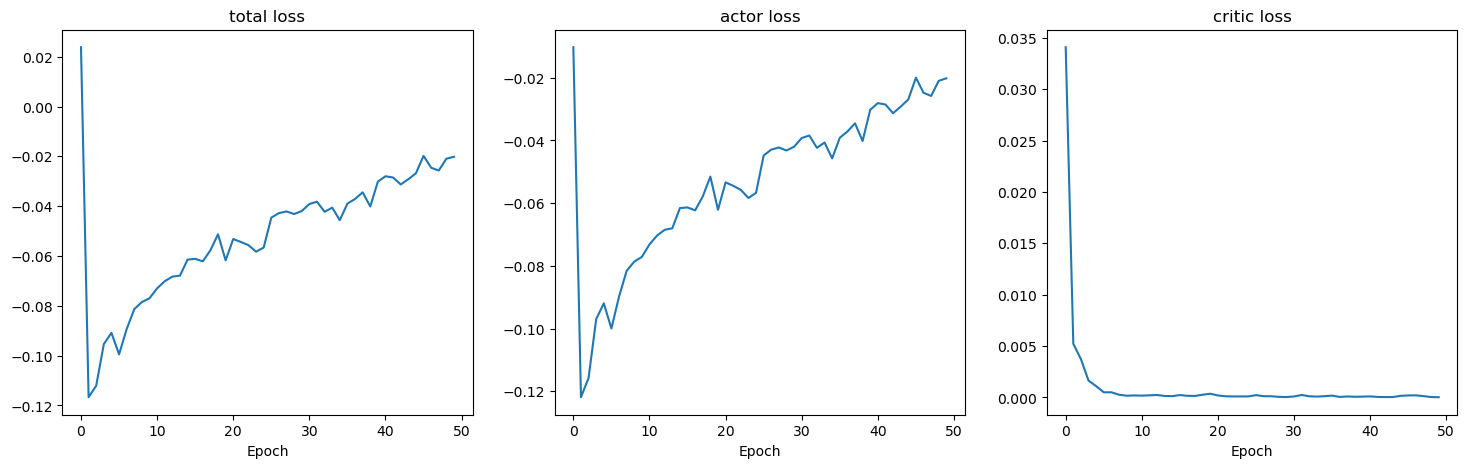

In [30]:
# Plot training curve
fig, ax = plt.subplots( 1, 3, figsize = (18, 5))
ax[0].plot(loss_hist)
ax[0].set_title("total loss")
ax[0].set_xlabel("Epoch")
ax[1].plot(actor_loss_hist)
ax[1].set_title("actor loss")
ax[1].set_xlabel("Epoch")
ax[2].plot(critic_loss_hist)
ax[2].set_title("critic loss")
ax[2].set_xlabel("Epoch")

## Evaluation

In [31]:
def sample_path(agent: Agent, actor: nn.Module, drug: int, disease: int) -> list[int]:
    """Randomly samples a actor policy path starting from a drug node. 

    Path terminated in target disease is reached.

    Args:
        agent: Instance of Agent class.
        actor: Actor network. 
        drug: igraph index for the source drug.
        disease: igraph index for the target disease.

    Returns:
        List of igraph indices.
    """
    # Reset agent
    agent.set_source_target(drug, disease)
    # Compute path
    path = [agent.current_node]
    while agent.terminated == False:
        probs_next_action = actor(agent.current_state_embedding, agent.all_actions_embeddings)
        n_next_action = random.choices(range(len(agent.all_actions)), weights = probs_next_action.tolist())[0]
        agent.select_next_action(n_next_action)    
        path.append(agent.current_node)
        if agent.current_node == disease:
            return path
    return path

In [32]:
def give_hits_list(
        n_samples : int,
        n_datapoints : int,
        f_sample: callable,
        dataset : list[tuple[int]]
    ) -> list:
    """Gives number of samples until hit list for an actor policy. 

    Args:
        n_samples: Maximum number of 
        n_datapoints: Maximum number of datapoints. 
        f_sample: Function sampling paths from actor-agent.
        drug: igraph index for the source drug.
        disease: igraph index for the target disease.

    Returns:
        List of elements:
            - False if a path to disease was not found, otherwise,
            - number of samples it took to get a path to disease. 
    """
    hits_lst = []
    disease_reached = False
    for drug, disease in tqdm(dataset[:n_datapoints]):
        for n in range(n_samples):
            path = f_sample(drug, disease) 
            if path[-1] == disease:
                disease_reached = True
                hits_lst.append(n+1)
                break
        if not disease_reached:
            hits_lst.append(False)
        disease_reached = False

    return hits_lst

def give_hitk(hits_lst, k_lst):
    """_summary_

    Args:
        hits_lst: _description_
        k_lst: _description_
    """
    filter_hits_lst = [n for n in hits_lst if n != False]
    hitk = []
    for k in k_lst:
        hitk.append(sum([n <= k for n in filter_hits_lst]) / len(hits_lst)) 
    return hitk
    

In [33]:
# Baselines

def sample_random_path(agent: Agent, drug: int, disease: int) -> list[int]:
    """Randomly samples a actor policy path starting from a drug node. 

    Path terminates if target disease is reached.

    Args:
        agent: Instance of Agent class.
        drug: igraph index for the source drug.
        disease: igraph index for the target disease.

    Returns:
        List of igraph indices.
    """
    # Reset agent
    agent.set_source_target(drug, disease)
    # Compute path
    path = [agent.current_node]
    while agent.terminated == False:
        n_next_action = random.choices(range(len(agent.all_actions)))[0]
        agent.select_next_action(n_next_action)    
        path.append(agent.current_node)
        if agent.current_node == disease:
            return path
    return path

### Establishing baselines

In [34]:
K = 5
k_lst = [10, 100, 500, 1000]
n_samples = 1000
n_datapoints = 100
dataset = tp_test_lst
agent = Agent(K, kg_env)


#### Random walk

In [35]:
# Computing hits list for random walk 
f_random_sample = lambda drug, disease: sample_random_path(agent, drug, disease)
random_hits_list = give_hits_list(n_samples, n_datapoints, f_random_sample, dataset)

100%|██████████| 100/100 [01:29<00:00,  1.12it/s]


In [36]:
# Compute Hit@k for random walk
hitk_random =  give_hitk(random_hits_list, k_lst)
print("Random walk:")
for hitk_val, k in zip(hitk_random, k_lst): 
    print(f"Hit@{k}: {hitk_val}")


Random walk:
Hit@10: 0.02
Hit@100: 0.19
Hit@500: 0.55
Hit@1000: 0.7


#### Untrained network

In [37]:
# Computing hits list for untrained actor 
actor = ActorFCNN([10, 10], kg_env.N_emb, kg_env.N_edge_labels) 
f_untrained = lambda drug, disease: sample_path(agent, actor, drug, disease)
untrained_hits_list = give_hits_list(n_samples, n_datapoints, f_untrained, dataset)


100%|██████████| 100/100 [01:54<00:00,  1.15s/it]


In [38]:
# Compute Hit@k for untrained actor 
hitk_untrained =  give_hitk(untrained_hits_list, k_lst)
print("Untrained network:")
for hitk_val, k in zip(hitk_untrained, k_lst): 
    print(f"Hit@{k}: {hitk_val}")

Untrained network:
Hit@10: 0.03
Hit@100: 0.19
Hit@500: 0.56
Hit@1000: 0.66


#### Trained mini network

In [39]:
# Computing hits list for trained actor 
f_trained = lambda drug, disease: sample_path(agent, mini_actor, drug, disease)
trained_hits_list = give_hits_list(n_samples, n_datapoints, f_trained, dataset)

100%|██████████| 100/100 [01:12<00:00,  1.37it/s]


In [40]:
# Compute Hit@k for trained mini actor 
hitk_trained =  give_hitk(trained_hits_list, k_lst)
print("Trained mini network:")
for hitk_val, k in zip(hitk_trained, k_lst): 
    print(f"Hit@{k}: {hitk_val}")

Trained mini network:
Hit@10: 0.0
Hit@100: 0.0
Hit@500: 0.0
Hit@1000: 0.0


## Bigger network

In [41]:
# GPU training : crashes since embedding matrix is too large to be stored on GPU memory
# Initialise KG environment
#kg_env = KGEnv(KG_NODES_PATH, KG_NODES_HEADER_PATH, KG_EDGES_PATH, KG_EDGES_HEADER_PATH, GRAPHSAGE_EMB_PATH, device = 'mps')

In [43]:
# Model hyperparameters
K = 5
actor_neuron_lst = [1000,500, 100]
critic_neuron_lst = [1000,500, 100]

# Training parameters
N_epochs = 250
gamma =  0.9
epsilon = 0.05
M = 500 # (max) number of DD pairs in epoch
optimiser = lambda params : torch.optim.SGD(params, lr=0.003)

trained_actor, trained_critic, loss_hist, actor_loss_hist, critic_loss_hist = train(kg_env,
    K, 
    actor_neuron_lst,
    critic_neuron_lst,
    N_epochs,
    gamma,
    epsilon,
    M, 
    optimiser
)

100%|██████████| 500/500 [00:16<00:00, 30.77it/s]


Epoch 1. Rewards awarded: 6. Average loss: 0.049217131962306065.


100%|██████████| 500/500 [00:15<00:00, 33.19it/s]


Epoch 2. Rewards awarded: 7. Average loss: 0.0373885665329326.


100%|██████████| 500/500 [00:15<00:00, 32.62it/s]


Epoch 3. Rewards awarded: 8. Average loss: 0.02968619709491516.


100%|██████████| 500/500 [00:15<00:00, 32.68it/s]


Epoch 4. Rewards awarded: 4. Average loss: 0.0189022546211149.


100%|██████████| 500/500 [00:14<00:00, 33.53it/s]


Epoch 5. Rewards awarded: 7. Average loss: 0.02026002545755667.


100%|██████████| 500/500 [00:15<00:00, 32.75it/s]


Epoch 6. Rewards awarded: 7. Average loss: 0.017701525120126464.


100%|██████████| 500/500 [00:15<00:00, 32.76it/s]


Epoch 7. Rewards awarded: 6. Average loss: 0.012734907516534198.


100%|██████████| 500/500 [00:15<00:00, 32.34it/s]


Epoch 8. Rewards awarded: 6. Average loss: 0.011772304662726432.


100%|██████████| 500/500 [00:15<00:00, 32.84it/s]


Epoch 9. Rewards awarded: 9. Average loss: 0.01537664193184825.


100%|██████████| 500/500 [00:15<00:00, 32.96it/s]


Epoch 10. Rewards awarded: 6. Average loss: 0.008900258439592563.


100%|██████████| 500/500 [00:15<00:00, 33.06it/s]


Epoch 11. Rewards awarded: 6. Average loss: 0.008152858898871879.


100%|██████████| 500/500 [00:14<00:00, 34.41it/s]


Epoch 12. Rewards awarded: 4. Average loss: 0.004953992801322858.


100%|██████████| 500/500 [00:14<00:00, 35.10it/s]


Epoch 13. Rewards awarded: 8. Average loss: 0.008860529699218774.


100%|██████████| 500/500 [00:14<00:00, 34.91it/s]


Epoch 14. Rewards awarded: 7. Average loss: 0.008866973431493534.


100%|██████████| 500/500 [00:14<00:00, 34.88it/s]


Epoch 15. Rewards awarded: 8. Average loss: 0.010107668525938002.


100%|██████████| 500/500 [00:14<00:00, 34.85it/s]


Epoch 16. Rewards awarded: 8. Average loss: 0.00919077511903394.


100%|██████████| 500/500 [00:14<00:00, 35.09it/s]


Epoch 17. Rewards awarded: 9. Average loss: 0.011569155574348617.


100%|██████████| 500/500 [00:14<00:00, 35.14it/s]


Epoch 18. Rewards awarded: 6. Average loss: 0.006215745079023312.


100%|██████████| 500/500 [00:14<00:00, 35.01it/s]


Epoch 19. Rewards awarded: 6. Average loss: 0.0070071006285306785.


100%|██████████| 500/500 [00:13<00:00, 35.72it/s]


Epoch 20. Rewards awarded: 9. Average loss: 0.011768882580609898.


100%|██████████| 500/500 [00:14<00:00, 35.49it/s]


Epoch 21. Rewards awarded: 8. Average loss: 0.009853905180575868.


100%|██████████| 500/500 [00:14<00:00, 35.03it/s]


Epoch 22. Rewards awarded: 9. Average loss: 0.010591488641676883.


100%|██████████| 500/500 [00:14<00:00, 35.33it/s]


Epoch 23. Rewards awarded: 10. Average loss: 0.012491880556192086.


100%|██████████| 500/500 [00:14<00:00, 34.66it/s]


Epoch 24. Rewards awarded: 10. Average loss: 0.010766208103577393.


100%|██████████| 500/500 [00:14<00:00, 35.58it/s]


Epoch 25. Rewards awarded: 13. Average loss: 0.014325629250158576.


100%|██████████| 500/500 [00:14<00:00, 35.40it/s]


Epoch 26. Rewards awarded: 9. Average loss: 0.0080497844254387.


100%|██████████| 500/500 [00:14<00:00, 35.16it/s]


Epoch 27. Rewards awarded: 6. Average loss: 0.003992761891632654.


100%|██████████| 500/500 [00:14<00:00, 34.84it/s]


Epoch 28. Rewards awarded: 14. Average loss: 0.015897607084990342.


100%|██████████| 500/500 [00:14<00:00, 35.54it/s]


Epoch 29. Rewards awarded: 10. Average loss: 0.009610944101383136.


100%|██████████| 500/500 [00:15<00:00, 31.88it/s]


Epoch 30. Rewards awarded: 10. Average loss: 0.009281213619887544.


100%|██████████| 500/500 [00:16<00:00, 30.58it/s]


Epoch 31. Rewards awarded: 8. Average loss: 0.005871006195407366.


100%|██████████| 500/500 [00:14<00:00, 34.08it/s]


Epoch 32. Rewards awarded: 7. Average loss: 0.003963132618928286.


100%|██████████| 500/500 [00:14<00:00, 34.32it/s]


Epoch 33. Rewards awarded: 9. Average loss: 0.009942777582955387.


100%|██████████| 500/500 [00:14<00:00, 34.07it/s]


Epoch 34. Rewards awarded: 8. Average loss: 0.007705377218752499.


100%|██████████| 500/500 [00:14<00:00, 33.50it/s]


Epoch 35. Rewards awarded: 6. Average loss: 0.0052268392241955255.


100%|██████████| 500/500 [00:14<00:00, 33.81it/s]


Epoch 36. Rewards awarded: 11. Average loss: 0.011483953114709797.


100%|██████████| 500/500 [00:16<00:00, 30.56it/s]


Epoch 37. Rewards awarded: 6. Average loss: 0.00430213308132405.


100%|██████████| 500/500 [00:16<00:00, 30.69it/s]


Epoch 38. Rewards awarded: 10. Average loss: 0.011624978219838648.


100%|██████████| 500/500 [00:15<00:00, 32.45it/s]


Epoch 39. Rewards awarded: 8. Average loss: 0.005055446596346276.


100%|██████████| 500/500 [00:16<00:00, 31.25it/s]


Epoch 40. Rewards awarded: 15. Average loss: 0.017236037817090922.


100%|██████████| 500/500 [00:16<00:00, 29.68it/s]


Epoch 41. Rewards awarded: 10. Average loss: 0.008830981458631754.


100%|██████████| 500/500 [00:15<00:00, 32.60it/s]


Epoch 42. Rewards awarded: 10. Average loss: 0.009252680119147953.


100%|██████████| 500/500 [00:15<00:00, 32.38it/s]


Epoch 43. Rewards awarded: 11. Average loss: 0.011101732815127925.


100%|██████████| 500/500 [00:15<00:00, 32.54it/s]


Epoch 44. Rewards awarded: 9. Average loss: 0.008215450116840656.


100%|██████████| 500/500 [00:14<00:00, 33.65it/s]


Epoch 45. Rewards awarded: 11. Average loss: 0.008324087744620555.


100%|██████████| 500/500 [00:15<00:00, 33.28it/s]


Epoch 46. Rewards awarded: 11. Average loss: 0.009217255881129557.


100%|██████████| 500/500 [00:14<00:00, 34.28it/s]


Epoch 47. Rewards awarded: 14. Average loss: 0.014327923166032026.


100%|██████████| 500/500 [00:14<00:00, 33.88it/s]


Epoch 48. Rewards awarded: 11. Average loss: 0.010020842951254357.


100%|██████████| 500/500 [00:14<00:00, 33.94it/s]


Epoch 49. Rewards awarded: 10. Average loss: 0.005101240503451361.


100%|██████████| 500/500 [00:15<00:00, 33.22it/s]


Epoch 50. Rewards awarded: 13. Average loss: 0.011561872234832661.


100%|██████████| 500/500 [00:14<00:00, 33.48it/s]


Epoch 51. Rewards awarded: 14. Average loss: 0.01380277034601871.


100%|██████████| 500/500 [00:15<00:00, 33.12it/s]


Epoch 52. Rewards awarded: 15. Average loss: 0.01298533814771372.


100%|██████████| 500/500 [00:14<00:00, 34.00it/s]


Epoch 53. Rewards awarded: 13. Average loss: 0.01016860830510814.


100%|██████████| 500/500 [00:14<00:00, 34.11it/s]


Epoch 54. Rewards awarded: 14. Average loss: 0.012887431467345476.


100%|██████████| 500/500 [00:14<00:00, 33.50it/s]


Epoch 55. Rewards awarded: 11. Average loss: 0.009027511297989196.


100%|██████████| 500/500 [00:15<00:00, 33.17it/s]


Epoch 56. Rewards awarded: 17. Average loss: 0.01728212479158583.


100%|██████████| 500/500 [00:15<00:00, 32.80it/s]


Epoch 57. Rewards awarded: 12. Average loss: 0.008848633410262362.


100%|██████████| 500/500 [00:14<00:00, 34.27it/s]


Epoch 58. Rewards awarded: 13. Average loss: 0.012649692349254716.


100%|██████████| 500/500 [00:14<00:00, 33.98it/s]


Epoch 59. Rewards awarded: 11. Average loss: 0.01030319978864827.


100%|██████████| 500/500 [00:15<00:00, 32.51it/s]


Epoch 60. Rewards awarded: 11. Average loss: 0.010124605891405434.


100%|██████████| 500/500 [00:14<00:00, 34.38it/s]


Epoch 61. Rewards awarded: 13. Average loss: 0.013361606165715783.


100%|██████████| 500/500 [00:14<00:00, 33.98it/s]


Epoch 62. Rewards awarded: 10. Average loss: 0.008388748665378443.


100%|██████████| 500/500 [00:14<00:00, 35.41it/s]


Epoch 63. Rewards awarded: 18. Average loss: 0.019175678506225573.


100%|██████████| 500/500 [00:14<00:00, 35.24it/s]


Epoch 64. Rewards awarded: 18. Average loss: 0.01783328096929411.


100%|██████████| 500/500 [00:15<00:00, 32.92it/s]


Epoch 65. Rewards awarded: 18. Average loss: 0.015985815828592577.


100%|██████████| 500/500 [00:14<00:00, 34.59it/s]


Epoch 66. Rewards awarded: 16. Average loss: 0.012261826154366039.


100%|██████████| 500/500 [00:15<00:00, 33.09it/s]


Epoch 67. Rewards awarded: 20. Average loss: 0.02054949886651472.


100%|██████████| 500/500 [00:14<00:00, 33.84it/s]


Epoch 68. Rewards awarded: 14. Average loss: 0.011712051438086443.


100%|██████████| 500/500 [00:15<00:00, 32.95it/s]


Epoch 69. Rewards awarded: 16. Average loss: 0.01563719486153999.


100%|██████████| 500/500 [00:15<00:00, 32.44it/s]


Epoch 70. Rewards awarded: 18. Average loss: 0.01670089248175524.


100%|██████████| 500/500 [00:15<00:00, 33.17it/s]


Epoch 71. Rewards awarded: 14. Average loss: 0.014138019606070884.


100%|██████████| 500/500 [00:14<00:00, 35.22it/s]


Epoch 72. Rewards awarded: 16. Average loss: 0.014037352542862817.


100%|██████████| 500/500 [00:14<00:00, 34.56it/s]


Epoch 73. Rewards awarded: 19. Average loss: 0.019723756565974023.


100%|██████████| 500/500 [00:14<00:00, 35.05it/s]


Epoch 74. Rewards awarded: 16. Average loss: 0.015530038217909653.


100%|██████████| 500/500 [00:16<00:00, 30.59it/s]


Epoch 75. Rewards awarded: 25. Average loss: 0.024574904274033846.


100%|██████████| 500/500 [00:17<00:00, 29.36it/s]


Epoch 76. Rewards awarded: 20. Average loss: 0.01602677835790079.


100%|██████████| 500/500 [00:26<00:00, 19.20it/s]


Epoch 77. Rewards awarded: 24. Average loss: 0.025197199603223155.


100%|██████████| 500/500 [00:26<00:00, 18.91it/s]


Epoch 78. Rewards awarded: 22. Average loss: 0.02000936134578357.


100%|██████████| 500/500 [00:17<00:00, 28.05it/s]


Epoch 79. Rewards awarded: 23. Average loss: 0.022140946099211457.


100%|██████████| 500/500 [00:14<00:00, 34.19it/s]


Epoch 80. Rewards awarded: 23. Average loss: 0.024204619982170092.


100%|██████████| 500/500 [00:16<00:00, 30.44it/s]


Epoch 81. Rewards awarded: 18. Average loss: 0.020562366751940616.


100%|██████████| 500/500 [00:14<00:00, 35.63it/s]


Epoch 82. Rewards awarded: 20. Average loss: 0.020107376421763398.


100%|██████████| 500/500 [00:13<00:00, 36.90it/s]


Epoch 83. Rewards awarded: 25. Average loss: 0.02630871739409789.


100%|██████████| 500/500 [00:14<00:00, 34.91it/s]


Epoch 84. Rewards awarded: 25. Average loss: 0.02178138238257816.


100%|██████████| 500/500 [00:14<00:00, 34.49it/s]


Epoch 85. Rewards awarded: 26. Average loss: 0.024290166277462045.


100%|██████████| 500/500 [00:14<00:00, 34.36it/s]


Epoch 86. Rewards awarded: 21. Average loss: 0.02061517582966068.


100%|██████████| 500/500 [00:14<00:00, 34.87it/s]


Epoch 87. Rewards awarded: 29. Average loss: 0.03040877099791063.


100%|██████████| 500/500 [00:15<00:00, 31.59it/s]


Epoch 88. Rewards awarded: 23. Average loss: 0.02510650842863061.


100%|██████████| 500/500 [00:14<00:00, 35.20it/s]


Epoch 89. Rewards awarded: 27. Average loss: 0.027859252149757287.


100%|██████████| 500/500 [00:14<00:00, 35.33it/s]


Epoch 90. Rewards awarded: 31. Average loss: 0.0350617239158825.


100%|██████████| 500/500 [00:13<00:00, 36.26it/s]


Epoch 91. Rewards awarded: 38. Average loss: 0.03892597470780296.


100%|██████████| 500/500 [00:13<00:00, 36.32it/s]


Epoch 92. Rewards awarded: 34. Average loss: 0.032048892611721995.


100%|██████████| 500/500 [00:14<00:00, 33.56it/s]


Epoch 93. Rewards awarded: 22. Average loss: 0.0207543549913571.


100%|██████████| 500/500 [00:13<00:00, 36.01it/s]


Epoch 94. Rewards awarded: 32. Average loss: 0.03354348937312306.


100%|██████████| 500/500 [00:14<00:00, 35.33it/s]


Epoch 95. Rewards awarded: 27. Average loss: 0.026390715558941034.


100%|██████████| 500/500 [00:14<00:00, 35.67it/s]


Epoch 96. Rewards awarded: 28. Average loss: 0.028793112797949105.


100%|██████████| 500/500 [00:13<00:00, 35.94it/s]


Epoch 97. Rewards awarded: 26. Average loss: 0.02718798520960324.


100%|██████████| 500/500 [00:13<00:00, 36.05it/s]


Epoch 98. Rewards awarded: 25. Average loss: 0.027472669522949827.


100%|██████████| 500/500 [00:13<00:00, 36.85it/s]


Epoch 99. Rewards awarded: 29. Average loss: 0.033799401451775034.


100%|██████████| 500/500 [00:14<00:00, 35.13it/s]


Epoch 100. Rewards awarded: 40. Average loss: 0.04336056877287652.


100%|██████████| 500/500 [00:15<00:00, 32.80it/s]


Epoch 101. Rewards awarded: 23. Average loss: 0.022717906672412934.


100%|██████████| 500/500 [00:14<00:00, 33.86it/s]


Epoch 102. Rewards awarded: 36. Average loss: 0.03939980216962083.


100%|██████████| 500/500 [00:14<00:00, 35.19it/s]


Epoch 103. Rewards awarded: 29. Average loss: 0.029430925258678294.


100%|██████████| 500/500 [00:13<00:00, 36.35it/s]


Epoch 104. Rewards awarded: 31. Average loss: 0.036789818740867446.


100%|██████████| 500/500 [00:13<00:00, 36.04it/s]


Epoch 105. Rewards awarded: 33. Average loss: 0.0354662809402677.


100%|██████████| 500/500 [00:13<00:00, 36.54it/s]


Epoch 106. Rewards awarded: 26. Average loss: 0.0274709984347384.


100%|██████████| 500/500 [00:13<00:00, 36.47it/s]


Epoch 107. Rewards awarded: 35. Average loss: 0.03668842243261224.


100%|██████████| 500/500 [00:13<00:00, 36.22it/s]


Epoch 108. Rewards awarded: 37. Average loss: 0.0389903433822589.


100%|██████████| 500/500 [00:13<00:00, 37.18it/s]


Epoch 109. Rewards awarded: 38. Average loss: 0.038966344669867786.


100%|██████████| 500/500 [00:13<00:00, 37.39it/s]


Epoch 110. Rewards awarded: 30. Average loss: 0.028263058591136238.


100%|██████████| 500/500 [00:13<00:00, 36.90it/s]


Epoch 111. Rewards awarded: 36. Average loss: 0.03464560932090716.


100%|██████████| 500/500 [00:13<00:00, 36.17it/s]


Epoch 112. Rewards awarded: 26. Average loss: 0.025451997680615936.


100%|██████████| 500/500 [00:13<00:00, 37.30it/s]


Epoch 113. Rewards awarded: 37. Average loss: 0.039723916890804796.


100%|██████████| 500/500 [00:13<00:00, 37.35it/s]


Epoch 114. Rewards awarded: 36. Average loss: 0.03605819282546356.


100%|██████████| 500/500 [00:13<00:00, 37.00it/s]


Epoch 115. Rewards awarded: 32. Average loss: 0.03085132910429593.


100%|██████████| 500/500 [00:13<00:00, 36.59it/s]


Epoch 116. Rewards awarded: 35. Average loss: 0.032203096629624874.


100%|██████████| 500/500 [00:13<00:00, 36.84it/s]


Epoch 117. Rewards awarded: 36. Average loss: 0.0338670204458443.


100%|██████████| 500/500 [00:14<00:00, 35.57it/s]


Epoch 118. Rewards awarded: 27. Average loss: 0.02076772738864444.


100%|██████████| 500/500 [00:13<00:00, 36.45it/s]


Epoch 119. Rewards awarded: 41. Average loss: 0.039052677947664045.


100%|██████████| 500/500 [00:13<00:00, 36.33it/s]


Epoch 120. Rewards awarded: 34. Average loss: 0.02730521022943943.


100%|██████████| 500/500 [00:13<00:00, 35.79it/s]


Epoch 121. Rewards awarded: 29. Average loss: 0.023194900694819505.


100%|██████████| 500/500 [00:13<00:00, 36.86it/s]


Epoch 122. Rewards awarded: 35. Average loss: 0.032291201196620635.


100%|██████████| 500/500 [00:14<00:00, 35.25it/s]


Epoch 123. Rewards awarded: 24. Average loss: 0.020455335256223558.


100%|██████████| 500/500 [00:14<00:00, 33.83it/s]


Epoch 124. Rewards awarded: 37. Average loss: 0.03516951454611035.


100%|██████████| 500/500 [00:14<00:00, 34.39it/s]


Epoch 125. Rewards awarded: 34. Average loss: 0.02924608159481462.


100%|██████████| 500/500 [00:14<00:00, 34.55it/s]


Epoch 126. Rewards awarded: 33. Average loss: 0.030428150262640737.


100%|██████████| 500/500 [00:14<00:00, 33.79it/s]


Epoch 127. Rewards awarded: 27. Average loss: 0.022816490660387295.


100%|██████████| 500/500 [00:14<00:00, 34.68it/s]


Epoch 128. Rewards awarded: 36. Average loss: 0.03273459255430013.


100%|██████████| 500/500 [00:14<00:00, 33.86it/s]


Epoch 129. Rewards awarded: 35. Average loss: 0.028108677998313694.


100%|██████████| 500/500 [00:14<00:00, 33.65it/s]


Epoch 130. Rewards awarded: 30. Average loss: 0.024732459368532852.


100%|██████████| 500/500 [00:14<00:00, 34.76it/s]


Epoch 131. Rewards awarded: 33. Average loss: 0.02629846494220222.


100%|██████████| 500/500 [00:14<00:00, 34.46it/s]


Epoch 132. Rewards awarded: 35. Average loss: 0.02604634384149479.


100%|██████████| 500/500 [00:14<00:00, 33.60it/s]


Epoch 133. Rewards awarded: 34. Average loss: 0.028392606161239807.


100%|██████████| 500/500 [00:14<00:00, 34.50it/s]


Epoch 134. Rewards awarded: 35. Average loss: 0.02810038592601124.


100%|██████████| 500/500 [00:14<00:00, 34.17it/s]


Epoch 135. Rewards awarded: 29. Average loss: 0.024364959096026727.


100%|██████████| 500/500 [00:14<00:00, 34.32it/s]


Epoch 136. Rewards awarded: 30. Average loss: 0.025782846104069296.


100%|██████████| 500/500 [00:14<00:00, 33.77it/s]


Epoch 137. Rewards awarded: 34. Average loss: 0.026865594965337247.


100%|██████████| 500/500 [00:15<00:00, 33.10it/s]


Epoch 138. Rewards awarded: 24. Average loss: 0.015272720264926954.


100%|██████████| 500/500 [00:14<00:00, 33.72it/s]


Epoch 139. Rewards awarded: 28. Average loss: 0.022033679439636526.


100%|██████████| 500/500 [00:14<00:00, 33.42it/s]


Epoch 140. Rewards awarded: 30. Average loss: 0.025218042613704104.


100%|██████████| 500/500 [00:14<00:00, 33.97it/s]


Epoch 141. Rewards awarded: 34. Average loss: 0.03125157846787623.


100%|██████████| 500/500 [00:14<00:00, 34.77it/s]


Epoch 142. Rewards awarded: 36. Average loss: 0.035822386771347435.


100%|██████████| 500/500 [00:14<00:00, 35.38it/s]


Epoch 143. Rewards awarded: 37. Average loss: 0.034541040561678525.


100%|██████████| 500/500 [00:14<00:00, 34.87it/s]


Epoch 144. Rewards awarded: 32. Average loss: 0.024701574143798404.


100%|██████████| 500/500 [00:14<00:00, 33.99it/s]


Epoch 145. Rewards awarded: 30. Average loss: 0.027904048795541415.


100%|██████████| 500/500 [00:14<00:00, 34.21it/s]


Epoch 146. Rewards awarded: 32. Average loss: 0.0271812614554201.


100%|██████████| 500/500 [00:14<00:00, 33.85it/s]


Epoch 147. Rewards awarded: 29. Average loss: 0.02626165387619039.


100%|██████████| 500/500 [00:14<00:00, 35.47it/s]


Epoch 148. Rewards awarded: 31. Average loss: 0.025018284863840258.


100%|██████████| 500/500 [00:14<00:00, 35.09it/s]


Epoch 149. Rewards awarded: 36. Average loss: 0.03187288772630199.


100%|██████████| 500/500 [00:14<00:00, 34.39it/s]


Epoch 150. Rewards awarded: 41. Average loss: 0.03471567518216641.


100%|██████████| 500/500 [00:14<00:00, 34.34it/s]


Epoch 151. Rewards awarded: 34. Average loss: 0.026225755733243813.


100%|██████████| 500/500 [00:14<00:00, 33.45it/s]


Epoch 152. Rewards awarded: 32. Average loss: 0.025778188610797958.


100%|██████████| 500/500 [00:14<00:00, 34.72it/s]


Epoch 153. Rewards awarded: 34. Average loss: 0.02723405134185975.


100%|██████████| 500/500 [00:14<00:00, 33.73it/s]


Epoch 154. Rewards awarded: 30. Average loss: 0.02616373138579486.


100%|██████████| 500/500 [00:17<00:00, 29.27it/s]


Epoch 155. Rewards awarded: 29. Average loss: 0.027889846644194825.


100%|██████████| 500/500 [00:14<00:00, 34.62it/s]


Epoch 156. Rewards awarded: 37. Average loss: 0.031864716650712416.


100%|██████████| 500/500 [00:15<00:00, 32.85it/s]


Epoch 157. Rewards awarded: 29. Average loss: 0.026737930308324092.


100%|██████████| 500/500 [00:14<00:00, 35.47it/s]


Epoch 158. Rewards awarded: 39. Average loss: 0.03519956661347805.


100%|██████████| 500/500 [00:14<00:00, 33.46it/s]


Epoch 159. Rewards awarded: 26. Average loss: 0.019628344025370704.


100%|██████████| 500/500 [00:15<00:00, 33.16it/s]


Epoch 160. Rewards awarded: 33. Average loss: 0.02886942043995683.


100%|██████████| 500/500 [00:14<00:00, 33.95it/s]


Epoch 161. Rewards awarded: 35. Average loss: 0.0300761446260113.


100%|██████████| 500/500 [00:14<00:00, 34.67it/s]


Epoch 162. Rewards awarded: 41. Average loss: 0.035192734790027096.


100%|██████████| 500/500 [00:14<00:00, 34.13it/s]


Epoch 163. Rewards awarded: 27. Average loss: 0.017000311421585437.


100%|██████████| 500/500 [00:14<00:00, 33.58it/s]


Epoch 164. Rewards awarded: 27. Average loss: 0.01652123168695592.


100%|██████████| 500/500 [00:15<00:00, 33.23it/s]


Epoch 165. Rewards awarded: 31. Average loss: 0.02229519548679551.


100%|██████████| 500/500 [00:14<00:00, 33.77it/s]


Epoch 166. Rewards awarded: 31. Average loss: 0.018659549322369462.


100%|██████████| 500/500 [00:15<00:00, 33.02it/s]


Epoch 167. Rewards awarded: 33. Average loss: 0.024171055933851077.


100%|██████████| 500/500 [00:14<00:00, 34.54it/s]


Epoch 168. Rewards awarded: 28. Average loss: 0.01912700410332824.


100%|██████████| 500/500 [00:14<00:00, 34.77it/s]


Epoch 169. Rewards awarded: 31. Average loss: 0.020694834067136073.


100%|██████████| 500/500 [00:14<00:00, 34.18it/s]


Epoch 170. Rewards awarded: 32. Average loss: 0.022482167573865806.


100%|██████████| 500/500 [00:14<00:00, 34.16it/s]


Epoch 171. Rewards awarded: 39. Average loss: 0.03066050833471126.


100%|██████████| 500/500 [00:14<00:00, 34.39it/s]


Epoch 172. Rewards awarded: 37. Average loss: 0.027130780179611978.


100%|██████████| 500/500 [00:14<00:00, 33.64it/s]


Epoch 173. Rewards awarded: 26. Average loss: 0.012410592351473801.


100%|██████████| 500/500 [00:15<00:00, 33.17it/s]


Epoch 174. Rewards awarded: 30. Average loss: 0.02392999957570312.


100%|██████████| 500/500 [00:14<00:00, 33.58it/s]


Epoch 175. Rewards awarded: 35. Average loss: 0.026300919004282452.


100%|██████████| 500/500 [00:14<00:00, 33.81it/s]


Epoch 176. Rewards awarded: 36. Average loss: 0.02587557271679422.


100%|██████████| 500/500 [00:15<00:00, 31.80it/s]


Epoch 177. Rewards awarded: 38. Average loss: 0.023789492357643507.


100%|██████████| 500/500 [00:15<00:00, 32.32it/s]


Epoch 178. Rewards awarded: 27. Average loss: 0.01493580210265827.


100%|██████████| 500/500 [00:15<00:00, 32.91it/s]


Epoch 179. Rewards awarded: 33. Average loss: 0.02362440691621184.


100%|██████████| 500/500 [00:15<00:00, 31.74it/s]


Epoch 180. Rewards awarded: 31. Average loss: 0.01903542912698231.


100%|██████████| 500/500 [00:16<00:00, 31.08it/s]


Epoch 181. Rewards awarded: 34. Average loss: 0.024611659588238282.


100%|██████████| 500/500 [00:15<00:00, 33.01it/s]


Epoch 182. Rewards awarded: 33. Average loss: 0.021689679824424577.


100%|██████████| 500/500 [00:15<00:00, 31.93it/s]


Epoch 183. Rewards awarded: 37. Average loss: 0.026119699194467105.


100%|██████████| 500/500 [00:15<00:00, 33.21it/s]


Epoch 184. Rewards awarded: 38. Average loss: 0.0252598719914428.


100%|██████████| 500/500 [00:14<00:00, 33.99it/s]


Epoch 185. Rewards awarded: 26. Average loss: 0.015145238261457205.


100%|██████████| 500/500 [00:14<00:00, 35.06it/s]


Epoch 186. Rewards awarded: 36. Average loss: 0.026558002847527552.


100%|██████████| 500/500 [00:14<00:00, 34.96it/s]


Epoch 187. Rewards awarded: 32. Average loss: 0.017180233193320113.


100%|██████████| 500/500 [00:14<00:00, 34.89it/s]


Epoch 188. Rewards awarded: 39. Average loss: 0.029070379262098867.


100%|██████████| 500/500 [00:14<00:00, 33.78it/s]


Epoch 189. Rewards awarded: 22. Average loss: 0.005699407410580534.


100%|██████████| 500/500 [00:15<00:00, 32.42it/s]


Epoch 190. Rewards awarded: 32. Average loss: 0.019545135566721605.


100%|██████████| 500/500 [00:14<00:00, 35.53it/s]


Epoch 191. Rewards awarded: 38. Average loss: 0.0245962771887063.


100%|██████████| 500/500 [00:14<00:00, 34.59it/s]


Epoch 192. Rewards awarded: 31. Average loss: 0.018151390268667456.


100%|██████████| 500/500 [00:14<00:00, 34.23it/s]


Epoch 193. Rewards awarded: 31. Average loss: 0.01855499215337355.


100%|██████████| 500/500 [00:14<00:00, 35.23it/s]


Epoch 194. Rewards awarded: 46. Average loss: 0.03155749560588174.


100%|██████████| 500/500 [00:14<00:00, 34.59it/s]


Epoch 195. Rewards awarded: 25. Average loss: 0.009539565310370864.


100%|██████████| 500/500 [00:14<00:00, 34.35it/s]


Epoch 196. Rewards awarded: 36. Average loss: 0.023641570442093626.


100%|██████████| 500/500 [00:15<00:00, 32.75it/s]


Epoch 197. Rewards awarded: 29. Average loss: 0.015099951248314028.


100%|██████████| 500/500 [00:14<00:00, 34.76it/s]


Epoch 198. Rewards awarded: 35. Average loss: 0.020352807895939812.


100%|██████████| 500/500 [00:14<00:00, 35.06it/s]


Epoch 199. Rewards awarded: 39. Average loss: 0.025162560402047802.


100%|██████████| 500/500 [00:15<00:00, 32.87it/s]


Epoch 200. Rewards awarded: 33. Average loss: 0.0155938296414212.


100%|██████████| 500/500 [00:16<00:00, 30.07it/s]


Epoch 201. Rewards awarded: 30. Average loss: 0.012137390179684494.


100%|██████████| 500/500 [00:16<00:00, 29.82it/s]


Epoch 202. Rewards awarded: 36. Average loss: 0.02242029826854347.


100%|██████████| 500/500 [00:14<00:00, 33.34it/s]


Epoch 203. Rewards awarded: 37. Average loss: 0.022695919255069988.


100%|██████████| 500/500 [00:15<00:00, 31.67it/s]


Epoch 204. Rewards awarded: 33. Average loss: 0.015556475915165112.


100%|██████████| 500/500 [00:14<00:00, 33.33it/s]


Epoch 205. Rewards awarded: 39. Average loss: 0.02337974137542066.


100%|██████████| 500/500 [00:14<00:00, 34.72it/s]


Epoch 206. Rewards awarded: 33. Average loss: 0.014481741613200328.


100%|██████████| 500/500 [00:14<00:00, 34.71it/s]


Epoch 207. Rewards awarded: 37. Average loss: 0.02154233487339236.


100%|██████████| 500/500 [00:14<00:00, 35.68it/s]


Epoch 208. Rewards awarded: 32. Average loss: 0.01596375892145867.


100%|██████████| 500/500 [00:14<00:00, 34.65it/s]


Epoch 209. Rewards awarded: 30. Average loss: 0.012753767233615996.


100%|██████████| 500/500 [00:14<00:00, 34.70it/s]


Epoch 210. Rewards awarded: 41. Average loss: 0.02360676162270829.


100%|██████████| 500/500 [00:14<00:00, 35.29it/s]


Epoch 211. Rewards awarded: 35. Average loss: 0.012190175504417006.


100%|██████████| 500/500 [00:13<00:00, 36.01it/s]


Epoch 212. Rewards awarded: 41. Average loss: 0.0220498256443243.


100%|██████████| 500/500 [00:14<00:00, 34.84it/s]


Epoch 213. Rewards awarded: 32. Average loss: 0.012146742616290191.


100%|██████████| 500/500 [00:14<00:00, 34.87it/s]


Epoch 214. Rewards awarded: 31. Average loss: 0.011405905433811007.


100%|██████████| 500/500 [00:14<00:00, 34.31it/s]


Epoch 215. Rewards awarded: 29. Average loss: 0.011968458417792894.


100%|██████████| 500/500 [00:14<00:00, 34.36it/s]


Epoch 216. Rewards awarded: 31. Average loss: 0.011016668636401543.


100%|██████████| 500/500 [00:14<00:00, 35.31it/s]


Epoch 217. Rewards awarded: 34. Average loss: 0.014231583249343508.


100%|██████████| 500/500 [00:14<00:00, 33.87it/s]


Epoch 218. Rewards awarded: 31. Average loss: 0.01449557554890513.


100%|██████████| 500/500 [00:13<00:00, 36.08it/s]


Epoch 219. Rewards awarded: 38. Average loss: 0.01993715660708404.


100%|██████████| 500/500 [00:14<00:00, 34.40it/s]


Epoch 220. Rewards awarded: 34. Average loss: 0.01295522963463797.


100%|██████████| 500/500 [00:14<00:00, 35.58it/s]


Epoch 221. Rewards awarded: 37. Average loss: 0.01575550077426063.


100%|██████████| 500/500 [00:14<00:00, 34.34it/s]


Epoch 222. Rewards awarded: 32. Average loss: 0.009513260121426967.


100%|██████████| 500/500 [00:14<00:00, 34.80it/s]


Epoch 223. Rewards awarded: 36. Average loss: 0.013447690958738046.


100%|██████████| 500/500 [00:14<00:00, 34.51it/s]


Epoch 224. Rewards awarded: 30. Average loss: 0.00733449724518869.


100%|██████████| 500/500 [00:14<00:00, 34.26it/s]


Epoch 225. Rewards awarded: 29. Average loss: 0.0030339478800160565.


100%|██████████| 500/500 [00:14<00:00, 34.08it/s]


Epoch 226. Rewards awarded: 31. Average loss: 0.007875052093301445.


100%|██████████| 500/500 [00:14<00:00, 35.07it/s]


Epoch 227. Rewards awarded: 30. Average loss: 0.006842808596129281.


100%|██████████| 500/500 [00:13<00:00, 36.43it/s]


Epoch 228. Rewards awarded: 45. Average loss: 0.014417212560615249.


100%|██████████| 500/500 [00:14<00:00, 34.91it/s]


Epoch 229. Rewards awarded: 29. Average loss: 0.002195360008755717.


100%|██████████| 500/500 [00:14<00:00, 34.88it/s]


Epoch 230. Rewards awarded: 27. Average loss: 0.004708418793579767.


100%|██████████| 500/500 [00:15<00:00, 32.18it/s]


Epoch 231. Rewards awarded: 35. Average loss: 0.009280574287051724.


100%|██████████| 500/500 [00:19<00:00, 25.36it/s]


Epoch 232. Rewards awarded: 34. Average loss: 0.008994983045219064.


100%|██████████| 500/500 [00:18<00:00, 27.00it/s]


Epoch 233. Rewards awarded: 40. Average loss: 0.012905196132347255.


100%|██████████| 500/500 [00:19<00:00, 26.11it/s]


Epoch 234. Rewards awarded: 38. Average loss: 0.004921915233062464.


100%|██████████| 500/500 [00:19<00:00, 25.43it/s]


Epoch 235. Rewards awarded: 29. Average loss: 0.00014137612918481546.


100%|██████████| 500/500 [00:14<00:00, 33.72it/s]


Epoch 236. Rewards awarded: 28. Average loss: 0.0009869675095324055.


100%|██████████| 500/500 [00:14<00:00, 35.55it/s]


Epoch 237. Rewards awarded: 22. Average loss: -0.005939084865453575.


100%|██████████| 500/500 [00:13<00:00, 35.84it/s]


Epoch 238. Rewards awarded: 30. Average loss: 0.000710768523441704.


100%|██████████| 500/500 [00:14<00:00, 35.57it/s]


Epoch 239. Rewards awarded: 35. Average loss: 0.004308626386506755.


100%|██████████| 500/500 [00:13<00:00, 37.11it/s]


Epoch 240. Rewards awarded: 36. Average loss: 0.0028024679396415494.


100%|██████████| 500/500 [00:13<00:00, 36.67it/s]


Epoch 241. Rewards awarded: 28. Average loss: -0.002347497963772184.


100%|██████████| 500/500 [00:13<00:00, 36.50it/s]


Epoch 242. Rewards awarded: 34. Average loss: -0.0012757613837244813.


100%|██████████| 500/500 [00:14<00:00, 35.05it/s]


Epoch 243. Rewards awarded: 33. Average loss: 0.0005757563281246496.


100%|██████████| 500/500 [00:13<00:00, 36.89it/s]


Epoch 244. Rewards awarded: 37. Average loss: 0.004142498066628226.


100%|██████████| 500/500 [00:13<00:00, 36.75it/s]


Epoch 245. Rewards awarded: 36. Average loss: 0.002042210161391267.


100%|██████████| 500/500 [00:13<00:00, 36.11it/s]


Epoch 246. Rewards awarded: 32. Average loss: 4.990174707319995e-06.


100%|██████████| 500/500 [00:13<00:00, 36.09it/s]


Epoch 247. Rewards awarded: 39. Average loss: 0.0016771545742528065.


100%|██████████| 500/500 [00:27<00:00, 18.37it/s]


Epoch 248. Rewards awarded: 39. Average loss: -0.0011876483306817436.


100%|██████████| 500/500 [00:43<00:00, 11.55it/s]


Epoch 249. Rewards awarded: 27. Average loss: -0.006591729646139962.


100%|██████████| 500/500 [00:13<00:00, 36.58it/s]

Epoch 250. Rewards awarded: 38. Average loss: 0.000323071547429814.


In [44]:
torch.save(trained_actor, 'output/actor.pt')
torch.save(trained_critic, 'output/critic.pt')

Text(0.5, 0, 'Epoch')

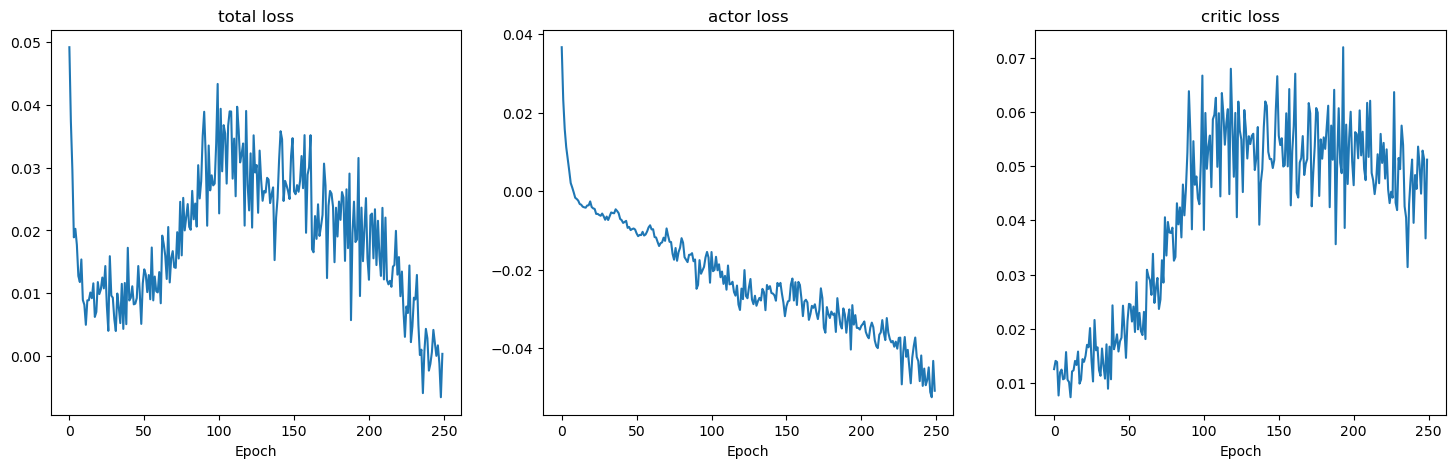

In [45]:
# Plot training curve
fig, ax = plt.subplots( 1, 3, figsize = (18, 5))
ax[0].plot(loss_hist)
ax[0].set_title("total loss")
ax[0].set_xlabel("Epoch")
ax[1].plot(actor_loss_hist)
ax[1].set_title("actor loss")
ax[1].set_xlabel("Epoch")
ax[2].plot(critic_loss_hist)
ax[2].set_title("critic loss")
ax[2].set_xlabel("Epoch")

In [46]:
# Computing hits list for trained actor 
f_trained = lambda drug, disease: sample_path(agent, trained_actor, drug, disease)
trained_hits_list = give_hits_list(n_samples, n_datapoints, f_trained, dataset)

100%|██████████| 100/100 [00:17<00:00,  5.77it/s]


In [47]:
# Compute Hit@k for trained actor 
hitk_trained =  give_hitk(trained_hits_list, k_lst)
print("Trained network:")
for hitk_val, k in zip(hitk_trained, k_lst): 
    print(f"Hit@{k}: {hitk_val}")

Trained network:
Hit@10: 0.48
Hit@100: 0.71
Hit@500: 0.86
Hit@1000: 0.94
